# **Dataset 4 - Coronavirus tweets NLP - Text Classification**

**Description**
The "Coronavirus Tweets NLP - Text Classification" dataset contains thousands of tweets during the COVID-19 pandemic. Each tweet is annotated with one of five sentiment labels: extremely positive, positive, neutral, negative, or extremely negative. The dataset includes the text of each tweet, the user's location, and the date it was posted, enabling detailed analysis of public sentiment and trends during the early phase of the pandemic.

**Source**
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

**Machine Learning Task**
Multi-class Classification

**Motivation**
Twitter posts provide a great source of text data, as they reflect opinions from users worldwide. This dataset focuses on tweets about the coronoavirus during a time of reduced social interaction. Analyzing sentiments during this period offers insights into how the pandemic affected public opinions, especially regarding negative sentiments.

**Objective**
Develop a model to classify the sentiment expressed in tweets, aiding in sentiment analysis, trend detection, and public opinion monitoring during health crises.

The two machine learning models that will be used in this classification are Logistic Regression and Random Forest Classifier.

In [70]:
# # optional code cell when using Google Colab with Google Drive
# # mount Google Drive in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# # change directory using the magic command %cd
# ### replace [MY PATH] below with your own path in Google Drive ###
# %cd /content/drive/My\ Drive/Fall 2024/ECE443/Term Project/Coronavirus Tweets NLP - Text Classification

In [71]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from wordcloud import WordCloud
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import time

# Brief Exploration of the Dataset

In this section, Exploratory Data Analysis (EDA) is performed on the dataset to gain insight into the context, dimensionality, and common patterns in the data that will be handled and noted for pre-processing and future work.

In [72]:
# Read the train data CSV file into a dataframe
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='Latin-1')

# Read the test data CSV file into a dataframe - NOTE: test set shall only be used for evaluations of models, but will have same processing applied to it (NO DATA LEAKAGE)
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='Latin-1')

# Display all columns
print("Columns:")
display(train_df.columns)

# Display dtypes
print("\nData Types:")
display(train_df.dtypes)

# Display the first 10 rows of the train dataset
print("\nFirst 10 rows:")
train_df.head()

Columns:


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


Data Types:


UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


First 10 rows:


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


There are six columns in the dataset: UserName (identifier, name), ScreenName (identifier, screen name), Location (where the Tweet originated from), TweetAt (the date the tweet was posted), OriginalTweet (the raw twitter text), and Sentiment (the label). There are *3 raw features*: Location, TweetAt, and OriginalTweet. There are *3 categorical variables*: Location, TweetAt, and Sentiment. There is currently *1 text data variable*: OriginalTweet. The output target variable is Sentiment.

The UserName and ScreenName columns are simply identifiers and are not considered as part of the feature or target variables.

In [73]:
# Get the number of samples
num_samples = len(train_df)
print(f"Number of samples: {num_samples}")

# Get the fraction of missing values
missing_values = train_df.isnull().sum() / num_samples
print(f"\nFraction of missing values: \n{missing_values}")

# Get the number of unique values in each column
unique_values = train_df.nunique()
print(f"\nNumber of unique values: \n{unique_values}")

# Get the number of (if any) duplicate samples
duplicate_samples = train_df.duplicated().sum()
print(f"\nNumber of duplicate samples: {duplicate_samples}")

Number of samples: 41157

Fraction of missing values: 
UserName         0.000000
ScreenName       0.000000
Location         0.208713
TweetAt          0.000000
OriginalTweet    0.000000
Sentiment        0.000000
dtype: float64

Number of unique values: 
UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

Number of duplicate samples: 0


There are 41,157 data samples in the training dataset. Only the Location column has missing values (roughly 20.9% of the column has missing values). Based on the analysis of the number of unique values in each column, the UserName, ScreenName, and OriginalTweet columns have distinct values. The Location, TweetAt, and Sentiment columns have non-unique values.

In [74]:
# # Generate a word cloud to analyze the frequency of words that appear in the Tweets
# tweet_text = train_df['OriginalTweet'].str.cat(sep=' ')
# wordcloud = WordCloud(
#     background_color='white'
# ).generate(tweet_text)

# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

As shown in the WordCloud, some of the most common words used in the Tweets include irrelevant words such as "https", "amp", "t", "co", etc. which are associated with links and other text that has no true bearing on the sentiment or expressions behind the text. Nonetheless, as expected, some more useful common words do surface, such as "COVID" (as expected), "supermarket", "price", "food", etc. which may influence the sentiment of the text.

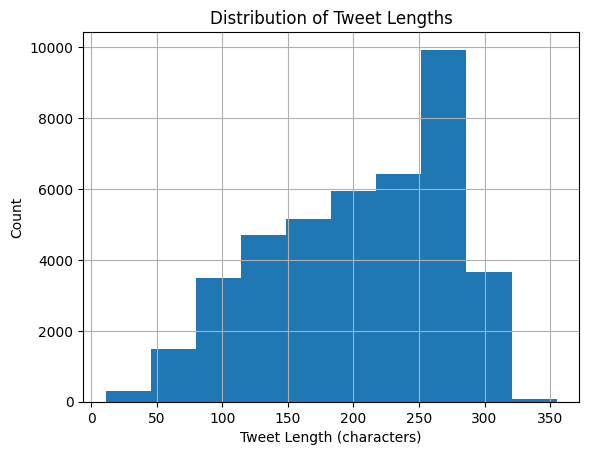

In [75]:
# Create histogram of the length of each tweet (number of characters)
train_df['OriginalTweet'].str.len().hist()
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Count')
plt.title('Distribution of Tweet Lengths')
plt.show()

As shown, the raw tweet lengths (in terms of number of characters in the text) are left-skewed, with the mode tweet length around 250 to 275 characters. Very few tweets are beyond 325 characters in length.

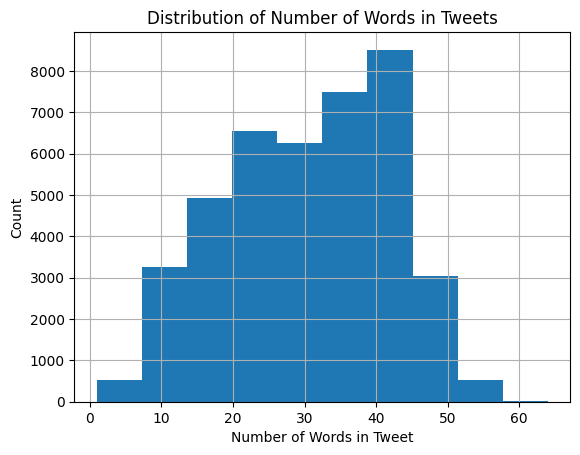

In [76]:
# Create a histogram of the number of words in each tweet
train_df['OriginalTweet'].str.split().map(lambda x : len(x)).hist()
plt.xlabel('Number of Words in Tweet')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Tweets')
plt.show()

As shown, the distribution of the number of words in a Tweet is roughly uniformly distributed, with the mean number of words in a Tweet hovering around 30 to 35 words.

Maximum length of any word in any Tweet: 279


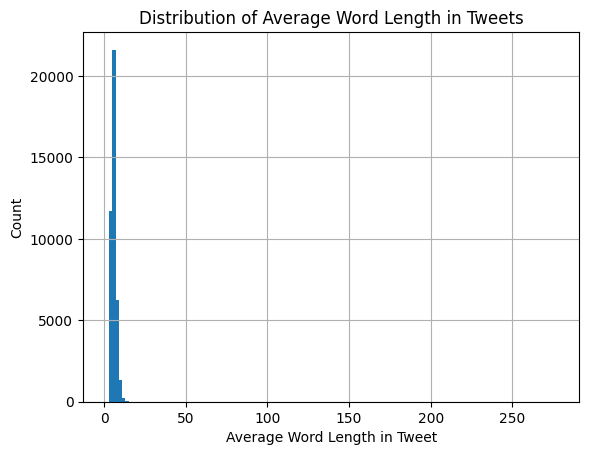

In [77]:
# Create a histogram of the average word length in each tweet
max_word_length = int(train_df['OriginalTweet'].str.split().map(lambda x : np.mean([len(word) for word in x])).max())
print(f"Maximum length of any word in any Tweet: {max_word_length}")

train_df['OriginalTweet'].str.split().map(lambda x : np.mean([len(word) for word in x])).hist(bins=[i for i in range(1, max_word_length, 2)])
plt.xlabel('Average Word Length in Tweet')
plt.ylabel('Count')
plt.title('Distribution of Average Word Length in Tweets')
plt.show()

As shown, the average length of the words in a Tweet is mostly from length 1 to 25. However, there are outliers, since the maximum average word length in a tweet is 279.

However, this does not directly imply that the Tweets only use very short words. For instance, the Tweets may contain stopwords, which are words most commonly used in the language ("the", "a", etc.). This is most likely causing the skew displayed in the distribution of average word lengths, so it is important to analyze how many and the types of stopwords there are in the Tweet text to gain more insight into the data.

The nltk library provides a corpus of stopwords from various languages; given the data exploration, however, the texts are in English, and so the English stopwords will be extracted from the corpus in the following exercise.

In [78]:
# Download nltk corpus and extract english stop words
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mogil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As shown, the extracted english stopwords from the nltk corpus are very common words in the English language, which are not as relevant towards the sentiment of the Tweets.

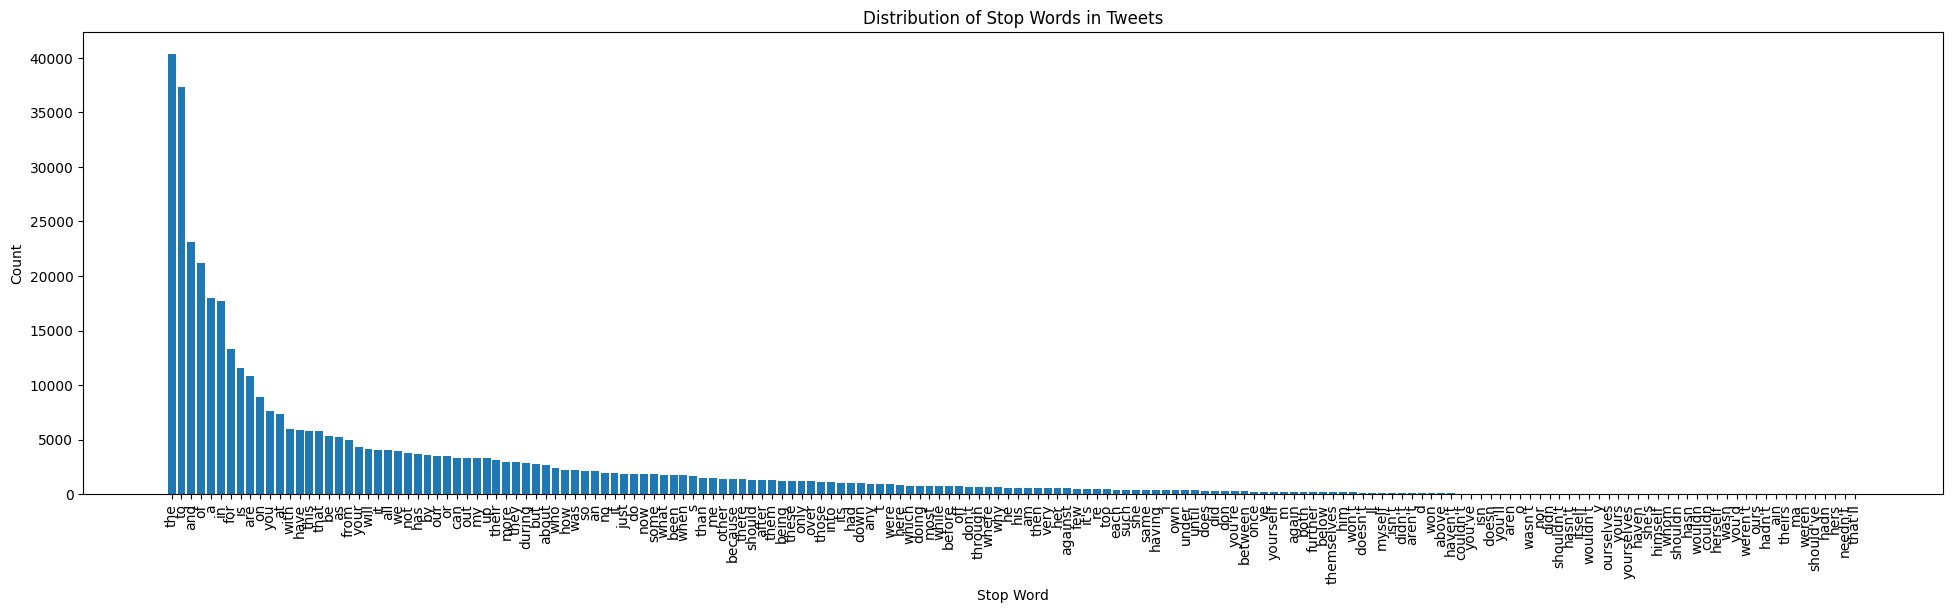

In [79]:
# Create corpus of all words from the Tweets
corpus = [word for tweet in train_df['OriginalTweet'].str.split().values.tolist() for word in tweet]

# Count how many times each stop word appears in the Tweets (using the corpus created above)
count_stop_words = defaultdict(int)
for word in corpus:
  if word in stop_words:
    count_stop_words[word] += 1

# Sort in decreasing frequency of stop words
count_stop_words = dict(sorted(count_stop_words.items(), key=lambda freq : freq[1], reverse=True))

# Plot the frequency of stop words in the Tweets
plt.figure(figsize=(24,6))
plt.bar(count_stop_words.keys(), count_stop_words.values())
plt.xlabel('Stop Word')
plt.ylabel('Count')
plt.title('Distribution of Stop Words in Tweets')
plt.xticks(rotation=90)
plt.show()

Thus, it is immediately evident that the Tweets collectively contain thousands of stop words, with the most common ones including "the", "to", "and", "of", "a", "in", "for", "is", "are", "on", "you", "at", etc.

The implications are that in the pre-processing of the data, in addition to words unrelated to sentiment such as "https", stopwords will also need to be filtered out to reduce the dimensionality of the numerical vectors representing the text data and reduce noise in the data when predicting sentiment. This is explored in greater detail in a future section.

Although the WordCloud provided a visualization of the top words in the Tweets, the actual count of the top 20 most common words in the Tweets can also be analyzed in the following exercise.

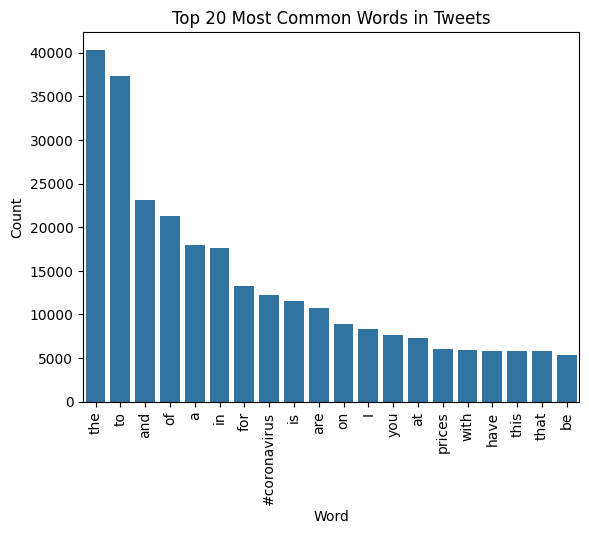

In [80]:
# Get the top 20 most common words in the Tweets
counter = Counter(corpus)
top_20_most_common_words = counter.most_common(20)

# Plot the top 20 most common words in the Tweets and their counts
word_list, count_list = zip(*top_20_most_common_words)
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 20 Most Common Words in Tweets')
plt.xticks(rotation=90)
plt.show()

Again, observe that so many of the most common words in the tweets are part of the stop words (compare with the distribution of stop words in the previous exercise). Stopwords like "the", "to", "and", etc. should be filtered from the Tweets' texts during the pre-processing stage.

Another exercise in exploring the text data involves exploring Ngrams, which are contiguous sequences of n words. For instance, N = 2 for "I am", N = 3 for "Who are you", etc. Exploring the most frequent Ngrams in the text data can provide insight into not just the words in the Tweets, but also their context windows. For the following exercise, Ngrams is implemented with the nltk.util module.

The Tweet text vocabulary is represented through the Countervectorizer method in sklearn.feature_engineering.text, which helps tokenize/vectorize and represent the corpus.

In [81]:
def get_top_Ngrams(corpus, n=1, top=10):
  """
  Retrieves the top Ngrams from the corpus.

  :param n: the top Ngrams to retrieve
  :param top: the number of top Ngrams to retrieve
  :return: a list of the top Ngrams based on decreasing frequency
  """
  vectorized = CountVectorizer(ngram_range=(n,n)).fit(corpus) # initialize a CountVectorizer that extracts n-grams of size n (e.g., for n=2, ["i like my phone"] = ["i like", "like my", "my phone"]) and fits the corpus to build vocab of n-grams
  bag_of_words = vectorized.transform(corpus) # convert corpus into sparse matrix bag of words, rows are documents and columns are counts of n-grams
  sum_of_words = bag_of_words.sum(axis=0) # collapse sparse matrix into one row, each column is total number of the n-gram for that corpus
  frequency_of_words = [(word, sum_of_words[0,index]) for word, index in vectorized.vocabulary_.items()] # the vocabulary_ is a dict mapping every n-gram to the sparse matrix index; this creates a list of tuples, each tuple is an n-gram with total count of it
  frequency_of_words = sorted(frequency_of_words, key=lambda x : x[1], reverse=True) # sort the n-grams by frequency
  return frequency_of_words[:top] # return the top n-grams

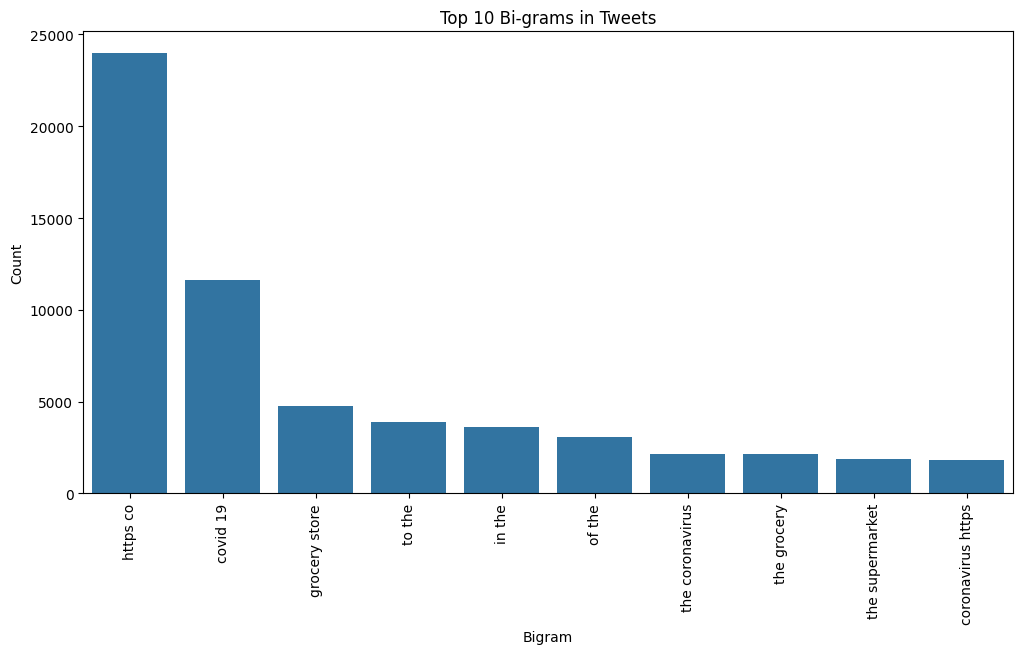

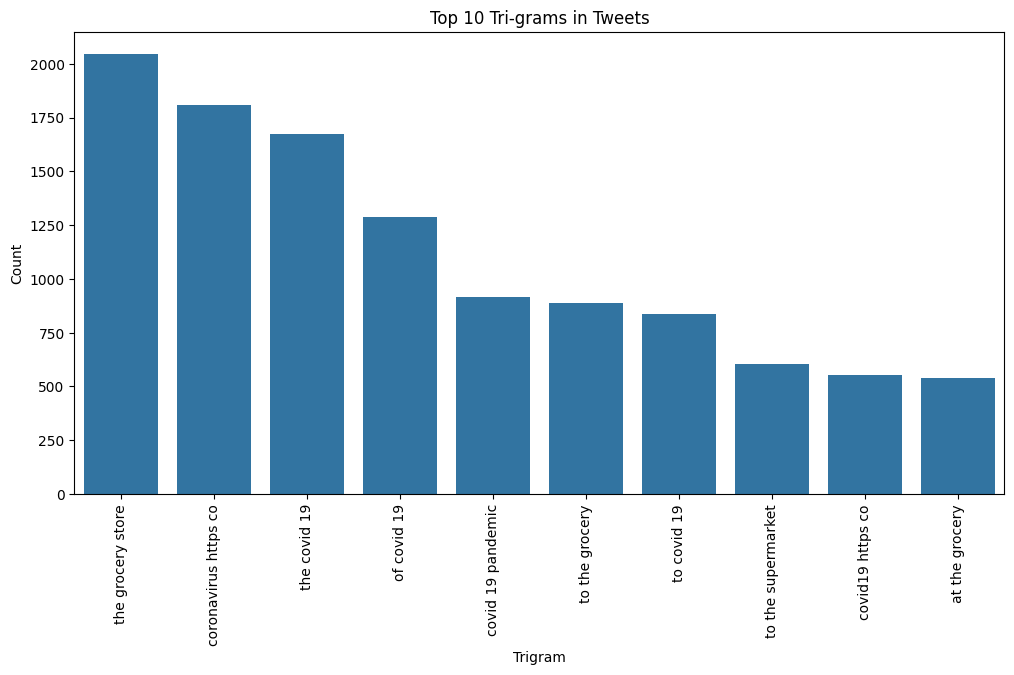

In [82]:
# Get the top 10 bi-grams from the Tweets
top_10_bigrams = get_top_Ngrams(train_df['OriginalTweet'], n=2, top=10)

# Plot the top 10 bi-grams from the Tweets
word_list, count_list = zip(*top_10_bigrams)
plt.figure(figsize=(12,6))
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Bigram')
plt.ylabel('Count')
plt.title('Top 10 Bi-grams in Tweets')
plt.xticks(rotation=90)
plt.show()

# Get the top 10 tri-grams from the Tweets
top_10_bigrams = get_top_Ngrams(train_df['OriginalTweet'], n=3, top=10)

# Plot the top 10 tri-grams from the Tweets
word_list, count_list = zip(*top_10_bigrams)
plt.figure(figsize=(12,6))
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Trigram')
plt.ylabel('Count')
plt.title('Top 10 Tri-grams in Tweets')
plt.xticks(rotation=90)
plt.show()

Based on the top 10 bi-grams and tri-grams from the Tweet text data, it seems like the "grocery" store and "supermarket" and "covid 19" are featured the most. Synonyms such as "grocery store" and "supermarket" can be combined into singular tokens during data cleaning and pre-processing. Also, it is again obvious that irrelevant words such as "https" and "co" appear in these Ngrams and will need to be filtered as well.

As a final exercise, the distribution of target classes (the sentiment labels) are explored.

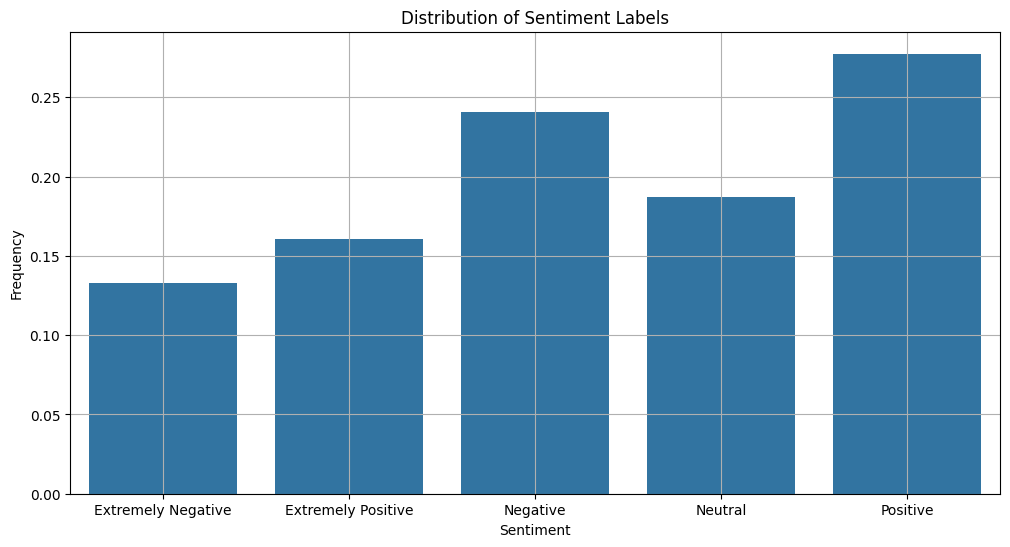

Sentiment
Extremely Negative    0.133173
Extremely Positive    0.160945
Negative              0.240955
Neutral               0.187404
Positive              0.277523
Name: Sentiment, dtype: float64

In [83]:
# Plot the frequency/empirical prior probability for each sentiment label class
sentiment_counts = train_df['Sentiment'].groupby(train_df['Sentiment']).count()
sentiment_frequencies = sentiment_counts / sentiment_counts.sum()

plt.figure(figsize=(12,6))
sns.barplot(x=sentiment_frequencies.index, y=sentiment_frequencies.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.grid()
plt.show()

sentiment_frequencies

The distribution of sentiment labels is not really uniform. The "Positive" sentiment class is most frequent with an empirical prior probability of 0.277523, followed by the "Negative" sentiment class with an empirical prior probability of 0.240955, followed by the "Neutral" sentiment class with an empirical prior probability of 0.187404, follwed by the "Extremely Positive" sentiment class with an empirical prior probability of 0.160945, followed by the "Extremely Negative" sentiment class with the lowest empirical prior probability of 0.133173.

# Pre-Processing of the Dataset

In this section, the dataset is preprocessed, which is guided by the previous section of exploration of the dataset as well as forthcoming plans for the dataset.

In [84]:
# Drop the Location and TweetAt columns
train_df.drop(['Location', 'TweetAt'], axis=1, inplace=True)

# Do the same on the test set
test_df.drop(['Location', 'TweetAt'], axis=1, inplace=True)

train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,My food stock is not the only one which is emp...,Positive
4,3803,48755,"Me, ready to go at supermarket during the #COV...",Extremely Negative


The first step of pre-processing the data involves directly dropping the Location and TweetAt columns in the dataframe. This is because the ultimate objective is to predict the sentiment class based on the Tweet text, which does not depend on the location the Tweet originated from nor the date the Tweet was posted.

Moreover, observe that there is no need for replacing invalid entries with plausible values, since during EDA, it was observed that only the Location column had invalid entries (such as NaN), which is being dropped from the dataframe.

Now, the Sentiment output variable has to be processed. Specifically, it is a categorical variable with 5 categories/classes ("Extremely Negative", "Negative", "Neutral", "Positive", and "Extremely Positive"). In fact, it is an *ordinal categorical variable* since there is a natural order/ranking of the classes (with no exact distance between): "Extremely Positive" > "Positive" > "Neutral" > "Negative" > "Extremely Negative". Therefore, the following exercise encodes the Sentiment categorical variable with *label encoding* to capture the natural ranking of the categories while transforming them into numerical values that can be processed in machine learning models.

In [85]:
# Define label encoding map for the 5 sentiment classes
sentiment_mapping = {
    "Extremely Positive": 4,
    "Positive": 3,
    "Neutral": 2,
    "Negative": 1,
    "Extremely Negative": 0
}

# Encode the Sentiment column with label encoding
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_mapping)

# Do the same for test set
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)

train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,3800,48752,advice Talk to your neighbours family to excha...,3
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,3
3,3802,48754,My food stock is not the only one which is emp...,3
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0


Now the Sentiment variable is label encoded. However, the original tweet data is still text data and is not currently fit to be fed into a machine learning model for processing, so it has to be encoded as well. This will be performed in the next section ("Feature Extraction/Feature Learning from the Dataset").

The other pending issue is that during EDA, it was discovered that the Tweet texts contained a lot of common words in the english language (stopwords) as well as irrelevant words such as non-alphanumeric data, URLs, punctuation, etc. The next exercise pre-processes and filters out such characters from the OriginalTweet text data.

In [86]:
def clean_text(text):
  """
  Removes any non-alphanumeric data, URLs, punctuation, and stop words (assuming english language) from the text and replaces with space.

  :param text: the text data to clean
  :return: the cleaned text data
  """
  # remove any URLs from the text data
  text = re.sub(r'http\S+', ' ', text)
  
  # remove tags
  text = re.sub(r'@\w*', ' ', text)
  
  # remove hashtags
  text = re.sub(r'#\w*', ' ', text)
  
  # remove apostrophes
  text = re.sub(r"'s\b", "", text)

  # remove any non-alphanumeric data from the text data
  text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
  
  # remove numbers
  text = re.sub('[\d]', ' ', text)
  
  # convert text to lowercase so it can be compared to stop words
  text = text.lower()

  # remove stop words from the text data
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text

In [87]:
# Apply the function defined above to each data sample in the training data to clean the Tweet texts
train_df['CleanedOriginalTweet'] = train_df['OriginalTweet'].apply(lambda x : clean_text(x))

# Do the same on the test set
test_df['CleanedOriginalTweet'] = test_df['OriginalTweet'].apply(lambda x : clean_text(x))

# Display the train dataframe with the new column for the clean Original Tweet
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,
1,3800,48752,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...
3,3802,48754,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...


In [88]:
# Print out the first 5 original tweet texts and cleaned original tweet texts in the dataframe
for original_tweet_text, cleaned_original_tweet_text in zip(train_df['OriginalTweet'].head(5), train_df['CleanedOriginalTweet'].head(5)):
  print(f"> Original Tweet Text: {original_tweet_text}\n")
  print(f"> Cleaned Original Tweet Text: {cleaned_original_tweet_text}\n")
  print("-" * 50)

> Original Tweet Text: @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8

> Cleaned Original Tweet Text: 

--------------------------------------------------
> Original Tweet Text: advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

> Cleaned Original Tweet Text: advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order

--------------------------------------------------
> Original Tweet Text: Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P

> Cleaned Original Tweet Text: coronavirus australia woolworths give elderly disab

As shown, after cleaning the tweet text data, there are now no URLs, non-alphanumeric data, punctuation, and stopwords in the text. This will help improve the efficiency and accuracy of the machine learning and language processing tasks that will be explored in a future section.

However, the text data can be processed further. While less relevant words were cleaned from the text data, recall that in EDA, another noted issue was that similar words or synonyms appeared in the Tweets. This can be approached with lemmatization and stemming, which are text pre-processing techniques used to reduce the inflected forms of words in the text data to a singular common root word (lemma). Both help convert the cleaned text data into a more structured format for processing in the machine learning models, by removing characters from the beginning and end of each word token. The largest distinction between the two methods is that lemmatization guarantees that the processed word is a true existing normalized version/lemma of the word from the dictionary, while stemming simply removes any common suffixes from the end of the word token (see https://www.ibm.com/think/topics/stemming-lemmatization).

The following exercise first lemmatizes the cleaned Tweet text data for each data sample.

In [89]:
def lemmatize_text(text, lemmatizer):
  """
  Lemmatizes the text data.

  :param text: the text data to clean
  :param lemmatizer: the lemmatizer to use
  :return: the lemmatized text data
  """
  # Lemmatize the text
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  return text

In [90]:
# Download wordnet from nltk and initialize the lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Use the function above to lemmatize each cleaned text data sample
train_df['LemmatizedCleanedOriginalTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : lemmatize_text(x, lemmatizer))

# Do the same for the test set
test_df['LemmatizedCleanedOriginalTweet'] = test_df['CleanedOriginalTweet'].apply(lambda x : lemmatize_text(x, lemmatizer))

# Display the train dataframe with the lemmatized clean Original Tweet
train_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mogil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,,
1,3800,48752,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...
3,3802,48754,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...


Stemming can also be applied to the text data to further process it and ensure a robust structured form of the text data. Stemming contains different algorithms that vary widely. Nonetheless, the general idea is to remove any word suffixes by comparing each word token again a pre-defined list of common suffixes. Then, the stemmer removes such suffixes from the word token.

In the following exercise, the *Porter stemming algorithm* is used, which based on research, seems to be the most widely used stemming algorithm (see https://www.ibm.com/think/topics/stemming-lemmatization). The Porter stemmer is chosen for this exercise because it only stems English words, which is already the context behind the dataset for this project. Had the Tweets contained other languages such as German, French, Russian, etc., the Snowball stemmer would have been more appropriate (see https://www.ibm.com/topics/stemming#:~:text=First%2C%20while%20the%20Lovins%20and,%2C%20French%2C%20and%20even%20Russian.).

In [91]:
def stem_text(text):
  """
  Stems the text data.

  :param text: the text data to clean
  :stemmer: the stemmer to use
  :return: the stemmed text data
  """
  # Initialize the stemmer, which will use the Porter Stemming algorithm
  stemmer = PorterStemmer()
  
  # Stem the text
  text = ' '.join([stemmer.stem(word) for word in text.split()])
  return text

In [92]:
# Use the function above to stem each cleaned text data sample - store in a new (stemmed) dataframe so the stemming is not added on top of the lemmatization for comparison
train_df['StemmedCleanedOriginalTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : stem_text(x))

# Do the same for the test set
test_df['StemmedCleanedOriginalTweet'] = test_df['CleanedOriginalTweet'].apply(lambda x : stem_text(x))

# Display the train dataframe with the stemmed clean Original Tweet
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet,StemmedCleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,,,
1,3800,48752,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...,advic talk neighbour famili exchang phone numb...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...,coronaviru australia woolworth give elderli di...
3,3802,48754,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...,food stock one empti pleas panic enough food e...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...,readi go supermarket outbreak paranoid food st...


In [93]:
def tokenize(text):
  tokens = re.findall(r'\b\w+\b', text)
  return tokens

train_df['TokenizedTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : tokenize(x))
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet,StemmedCleanedOriginalTweet,TokenizedTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,,,,[]
1,3800,48752,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...,advic talk neighbour famili exchang phone numb...,"[advice, talk, neighbours, family, exchange, p..."
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...,coronaviru australia woolworth give elderli di...,"[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...,food stock one empti pleas panic enough food e...,"[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...,readi go supermarket outbreak paranoid food st...,"[ready, go, supermarket, outbreak, paranoid, f..."


# Feature Extraction/Feature Learning from the Dataset


This section involves feature engineering/learning for this dataset, with the main focus of transforming the raw cleaned/processed Tweet text data into numerical features through a vectorizer.

In [94]:
from sklearn.model_selection import train_test_split

# Shuffle the data to prevent bias
shuffled_train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_lemmatized = shuffled_train_df["LemmatizedCleanedOriginalTweet"]
X_train_stemmed = shuffled_train_df["StemmedCleanedOriginalTweet"]
y_train = shuffled_train_df["Sentiment"]

# Same for test set
X_test_lemmatized = test_df["LemmatizedCleanedOriginalTweet"]
X_test_stemmed = test_df["StemmedCleanedOriginalTweet"]
y_test = test_df["Sentiment"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=111)

# Fit the TF-IDF Vectorizer on the lemmatized training data and transform both the train and test data using the vectorization (no data leakage b/c training data is used for transform)
tfidf_lemmatized_vectorizer = TfidfVectorizer()
X_train_lemmatized_tfidf = tfidf_lemmatized_vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_tfidf = tfidf_lemmatized_vectorizer.transform(X_test_lemmatized)

# Fit the TF-IDF Vectorizer on the lemmatized training data and transform both the train and test data using the vectorization (no data leakage b/c training data is used for transform)
tfidf_stemmed_vectorizer = TfidfVectorizer()
X_train_stemmed_tfidf = tfidf_stemmed_vectorizer.fit_transform(X_train_stemmed)
X_test_stemmed_tfidf = tfidf_stemmed_vectorizer.transform(X_test_stemmed)


# X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

print(f"Lemmatized, TF-IDF X_train has {X_train_lemmatized_tfidf.shape[0]} data samples and {X_train_lemmatized_tfidf.shape[1]} features.")
print(f"Stemmed, TF-IDF X_train has {X_train_stemmed_tfidf.shape[0]} data samples and {X_train_stemmed_tfidf.shape[1]} features.")

Lemmatized, TF-IDF X_train has 41157 data samples and 28708 features.
Stemmed, TF-IDF X_train has 41157 data samples and 22501 features.


# Processing of the Dataset Using Two Different Machine Learning Methods

In this section, the declared task of classifying a Tweet by predicting its sentiment is carried out using two different machine learning methods: (Multimodal) Logistic Regression and Support Vector Machine (SVM).

This section also presents tuning of both models using cross-validation, with the results averaged over multiple validation folds.

The final results are presented at the end of this section.

## K-Fold Cross Validation
K-Fold Cross Val

In [95]:
def get_kfolds(data, k=5):
  """
  Generates k-folds on the data.
  """
  fold_length = data.shape[0] // k # Size of each fold
  kfolds = [] # Stores tuples containing the indices for the test fold and train folds for each iteration i = 0, 1, 2, ... , k-1
  fold_indices = np.arange(data.shape[0]) # indices of the data
  for i in range(k):
    test_fold = fold_indices[i * fold_length : (i + 1) * fold_length] # test fold indices
    train_folds = np.concatenate([fold_indices[ : i * fold_length], fold_indices[(i + 1) * fold_length : ]]) # indices of train folds (possibly before and after test fold)
    kfolds.append((train_folds, test_fold)) # store the indices of test fold and train folds for current iteration
  return kfolds # return all fold indices for all K iterations of cross validation

In [96]:
from itertools import product

def kfolds_CV(X, y, params, table_title, metric=accuracy_score, model_type=None):
    best_params = None
    best_score = 0
    results = []
    
    param_combinations = list(product(*params.values()))
    param_types = list(params.keys())
    
    for param_combination in param_combinations:
        param_dictionary = dict(zip(param_types, param_combination))
        
        if not model_type:
            break
        
        model = None
        
        if model_type == "LogisticRegression":
            if param_dictionary['penalty'] == 'l1' and param_dictionary['solver'] not in ['liblinear', 'saga']:
                continue
            model = LogisticRegression(C=param_dictionary['C'], penalty=param_dictionary['penalty'], solver=param_dictionary['solver'])
        elif model_type == "RandomForestClassifier":
            model = RandomForestClassifier(n_estimators=param_dictionary['n_estimators'], max_features=param_dictionary['max_features'])
        else:
          continue

        scores = []
        start_time = time.time()

        for train_folds, test_fold in get_kfolds(X):
            X_train_fold, y_train_fold = X[train_folds], y[train_folds]
            X_test_fold, y_test_fold = X[test_fold], y[test_fold]
            
            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_test_fold)
            score = metric(y_test_fold, y_pred)
            scores.append(score)

        end_time = time.time()
        
        run_time = end_time - start_time

        avg_score = np.mean(scores)
        results.append({"params": param_dictionary, "score": avg_score, "time(sec)": run_time})

        print(results[-1])

        if avg_score > best_score:
            best_score = avg_score
            best_params = param_dictionary
            
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.4f}\n")
    
    # Plot a summary of cross-validation results
    rows = []
    for res in results:
        row = res['params'].copy()
        row['score'] = res['score']
        row['time(sec)'] = res['time(sec)']
        rows.append(row)
        
    df = pd.DataFrame(rows)    
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    
    # Highlight the best combination of params determined through CV
    for col in range(len(df.columns)):
        table[(df['score'].idxmax() + 1, col)].set_facecolor('#ccffcc') # make it a green background
        
    ax.set_title(table_title, fontsize=16, weight='bold', pad=18)
    
    plt.show()
    
    return best_params, best_score

## Multimodal Logistic Regression

{'params': {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.2775361438464342, 'time(sec)': 0.7389712333679199}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.3052606001700887, 'time(sec)': 1.5527470111846924}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.3155145182845341, 'time(sec)': 1.4693071842193604}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.3155145182845341, 'time(sec)': 1.5265841484069824}
{'params': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.42488154537723244, 'time(sec)': 1.419940710067749}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.4694204835378447, 'time(sec)': 3.685291290283203}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.4880087474182967, 'time(sec)': 2.0013718605041504}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.4881788361073989, 'time(sec)': 1.8536036014556885}
{'params'

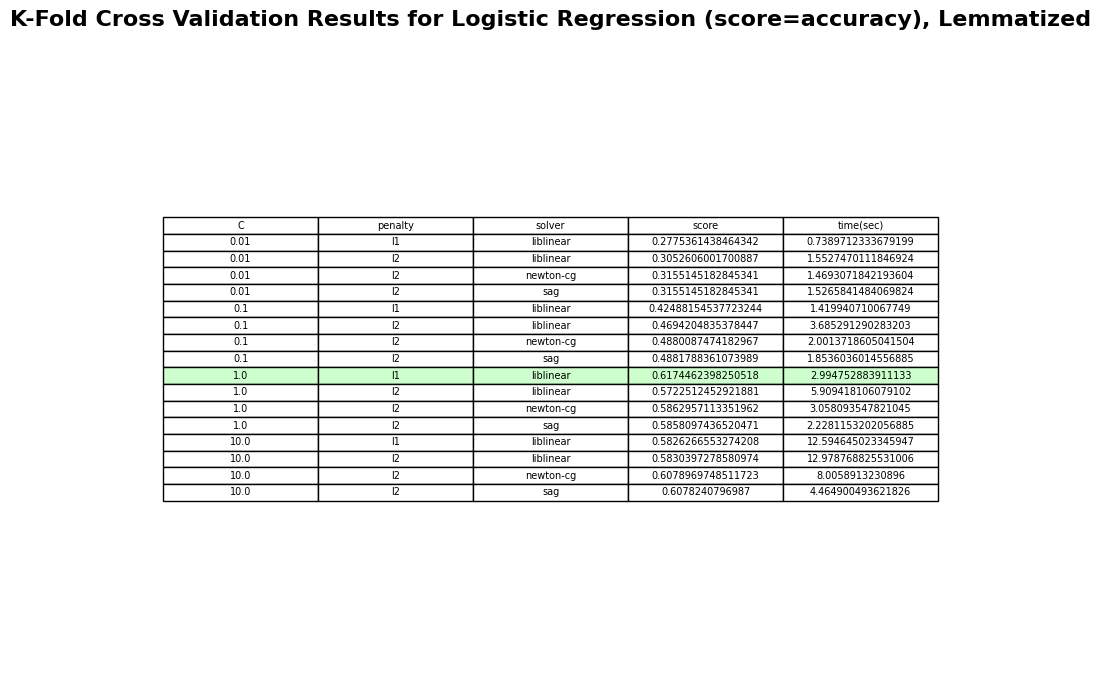

In [97]:
# Here, we use accuracy metric and run cross validation for lemmatized
lr_params = {'C': [0.01, 0.1, 1.0, 10.0],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear', 'newton-cg', 'sag']}

lr_best_params_lemmatized_accuracy, lr_best_score_lemmatized_accuracy = kfolds_CV(X_train_lemmatized_tfidf, y_train, lr_params, "K-Fold Cross Validation Results for Logistic Regression (score=accuracy), Lemmatized", accuracy_score, "LogisticRegression")

{'params': {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.08689463832476949, 'time(sec)': 0.7519989013671875}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.1338107800372974, 'time(sec)': 3.184103012084961}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.14795908543315983, 'time(sec)': 1.7587499618530273}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.14796538006264662, 'time(sec)': 1.884887933731079}
{'params': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.42663892383381735, 'time(sec)': 1.7532248497009277}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.4331612914371378, 'time(sec)': 4.383228302001953}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.45945187338032145, 'time(sec)': 2.3198626041412354}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.4595909255263321, 'time(sec)': 1.6982316970825195}
{'para

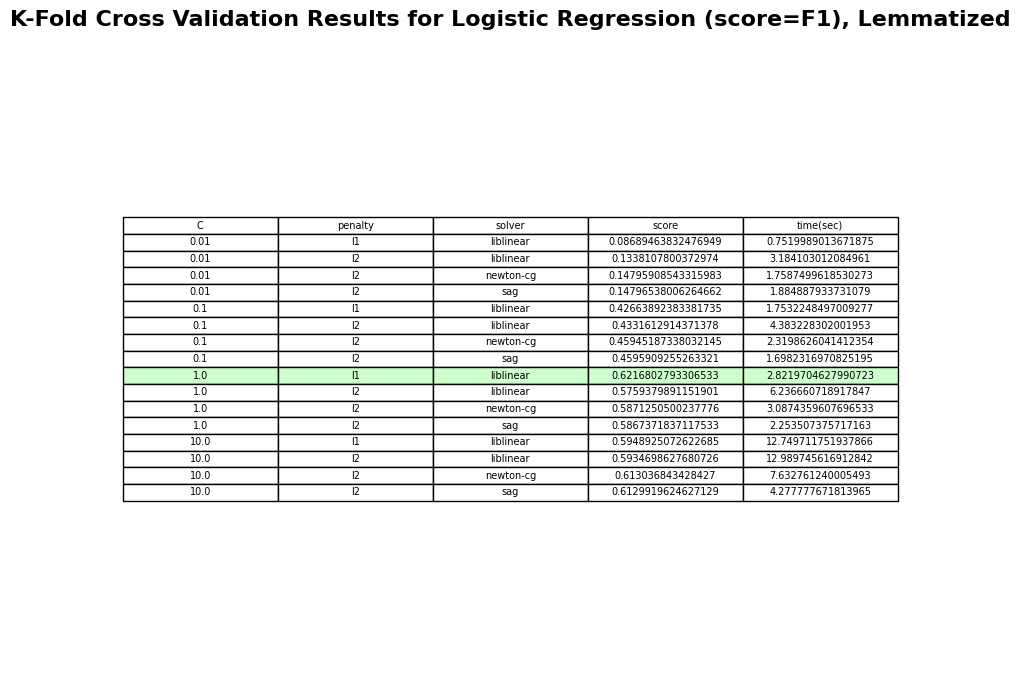

In [98]:
# Here, we use f1-score metric and run cross validation for lemmatized
lr_best_params_lemmatized_f1, lr_best_score_lemmatized_f1 = kfolds_CV(X_train_lemmatized_tfidf, y_train, lr_params, "K-Fold Cross Validation Results for Logistic Regression (score=F1), Lemmatized", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "LogisticRegression")

{'params': {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.2775361438464342, 'time(sec)': 0.7006604671478271}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.3111408091361924, 'time(sec)': 1.778634786605835}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.3229984206050297, 'time(sec)': 1.0598335266113281}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.3229984206050297, 'time(sec)': 1.5752339363098145}
{'params': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.43958206779249187, 'time(sec)': 1.5011711120605469}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.48579759445996845, 'time(sec)': 3.313007354736328}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.5018102296197303, 'time(sec)': 1.7347395420074463}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.5016887376989431, 'time(sec)': 1.6938889026641846}
{'params

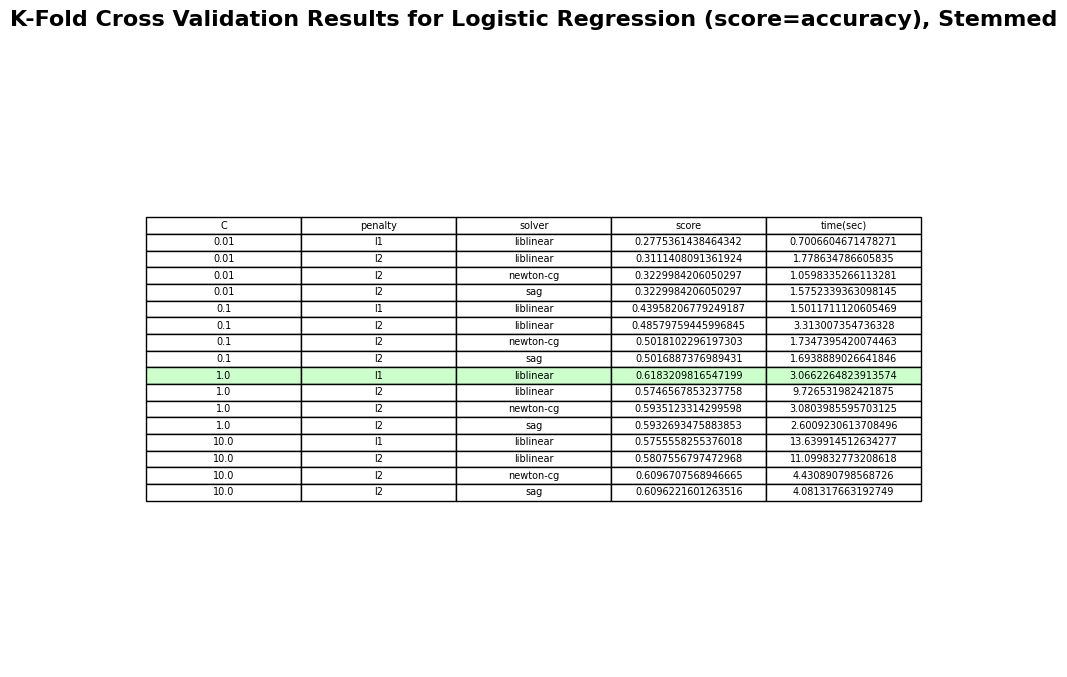

In [99]:
# Here, we use accuracy metric and run cross validation for stemmed
lr_best_params_stemmed_accuracy, lr_best_score_stemmed_accuracy = kfolds_CV(X_train_stemmed_tfidf, y_train, lr_params, "K-Fold Cross Validation Results for Logistic Regression (score=accuracy), Stemmed", accuracy_score, "LogisticRegression")

{'params': {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.08689463832476949, 'time(sec)': 0.6832468509674072}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.1414984701410817, 'time(sec)': 2.0435049533843994}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.1571937819327386, 'time(sec)': 1.023223638534546}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.1570655430277762, 'time(sec)': 1.4339592456817627}
{'params': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.4447403345580064, 'time(sec)': 1.4045112133026123}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.45673006160980484, 'time(sec)': 3.18630051612854}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.47832623991717493, 'time(sec)': 1.5885381698608398}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.4782233762799704, 'time(sec)': 1.5024454593658447}
{'params

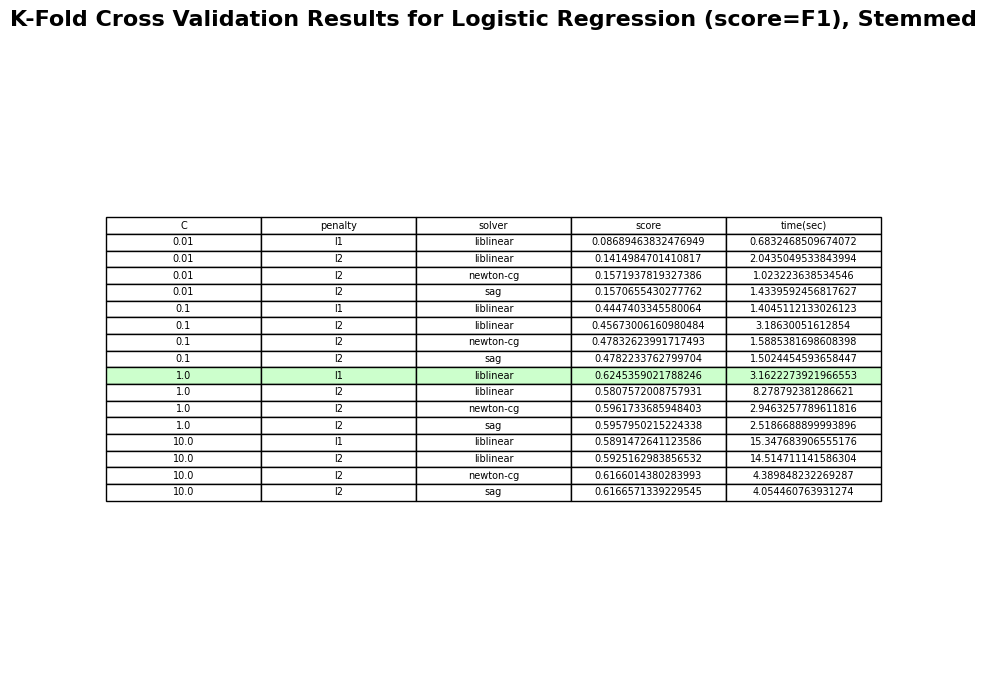

In [100]:
# Here, we use f1-score metric and run cross validation for stemmed
lr_best_params_stemmed_f1, lr_best_score_stemmed_f1 = kfolds_CV(X_train_stemmed_tfidf, y_train, lr_params, "K-Fold Cross Validation Results for Logistic Regression (score=F1), Stemmed", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "LogisticRegression")

## Random Forest Classifier

{'params': {'n_estimators': 10, 'max_features': 'log2'}, 'score': 0.4338962458996477, 'time(sec)': 88.63402986526489}
{'params': {'n_estimators': 10, 'max_features': 'sqrt'}, 'score': 0.49092455351719116, 'time(sec)': 80.3169617652893}
{'params': {'n_estimators': 50, 'max_features': 'log2'}, 'score': 0.5026606730652412, 'time(sec)': 456.92457914352417}
{'params': {'n_estimators': 50, 'max_features': 'sqrt'}, 'score': 0.5433361681448183, 'time(sec)': 399.7369384765625}
{'params': {'n_estimators': 100, 'max_features': 'log2'}, 'score': 0.5196452435913013, 'time(sec)': 909.0328359603882}
{'params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'score': 0.5519620945207143, 'time(sec)': 805.0661177635193}

Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best Score: 0.5520



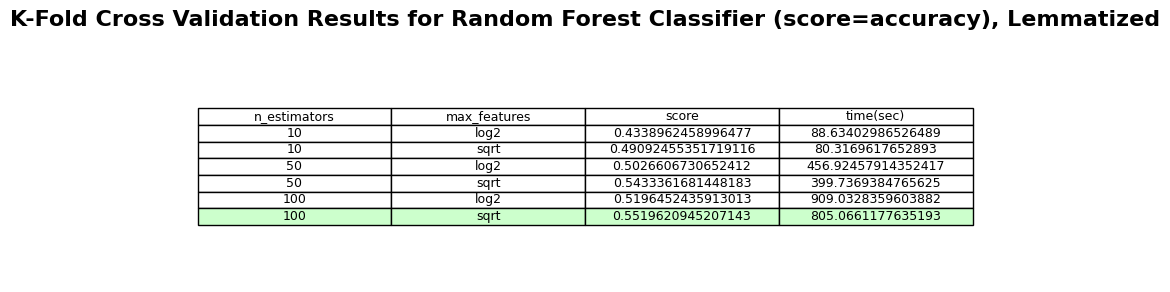

In [101]:
rf_params = {'n_estimators': [10, 50, 100],
             'max_features': ["log2", "sqrt"]}

rf_best_params_lemmatized_accuracy, rf_best_score_lemmatized_accuracy = kfolds_CV(X_train_lemmatized_tfidf, y_train, rf_params, "K-Fold Cross Validation Results for Random Forest Classifier (score=accuracy), Lemmatized", accuracy_score, "RandomForestClassifier")

{'params': {'n_estimators': 10, 'max_features': 'log2'}, 'score': 0.42710323570761133, 'time(sec)': 90.37612104415894}
{'params': {'n_estimators': 10, 'max_features': 'sqrt'}, 'score': 0.4878927570278965, 'time(sec)': 78.57202816009521}
{'params': {'n_estimators': 50, 'max_features': 'log2'}, 'score': 0.4873140315795276, 'time(sec)': 456.0151586532593}
{'params': {'n_estimators': 50, 'max_features': 'sqrt'}, 'score': 0.5402274107815938, 'time(sec)': 397.9896810054779}
{'params': {'n_estimators': 100, 'max_features': 'log2'}, 'score': 0.49791584635606717, 'time(sec)': 889.4201233386993}
{'params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'score': 0.5447383539680206, 'time(sec)': 790.9658010005951}

Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best Score: 0.5447



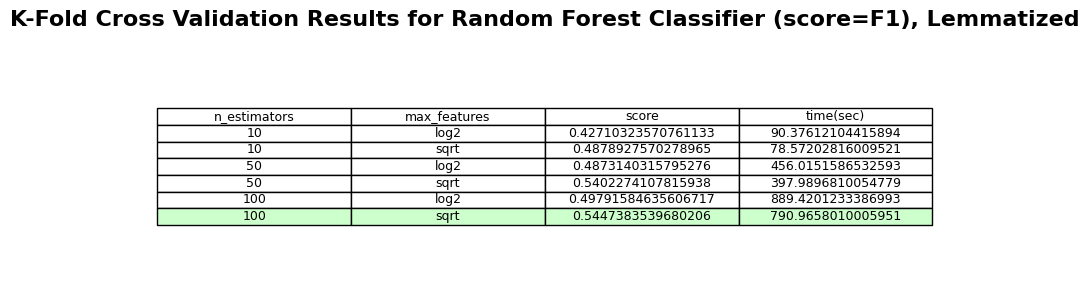

In [102]:
rf_best_params_lemmatized_f1, rf_best_score_lemmatized_f1 = kfolds_CV(X_train_lemmatized_tfidf, y_train, rf_params, "K-Fold Cross Validation Results for Random Forest Classifier (score=F1), Lemmatized", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "RandomForestClassifier")

{'params': {'n_estimators': 10, 'max_features': 'log2'}, 'score': 0.43508686672336294, 'time(sec)': 74.0210223197937}
{'params': {'n_estimators': 10, 'max_features': 'sqrt'}, 'score': 0.49211517434090635, 'time(sec)': 68.8258318901062}
{'params': {'n_estimators': 50, 'max_features': 'log2'}, 'score': 0.5033896245899647, 'time(sec)': 374.5575089454651}
{'params': {'n_estimators': 50, 'max_features': 'sqrt'}, 'score': 0.5518649009840846, 'time(sec)': 343.0053482055664}
{'params': {'n_estimators': 100, 'max_features': 'log2'}, 'score': 0.5172883003280282, 'time(sec)': 745.004222869873}
{'params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'score': 0.5604422305916656, 'time(sec)': 681.7895057201385}

Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best Score: 0.5604



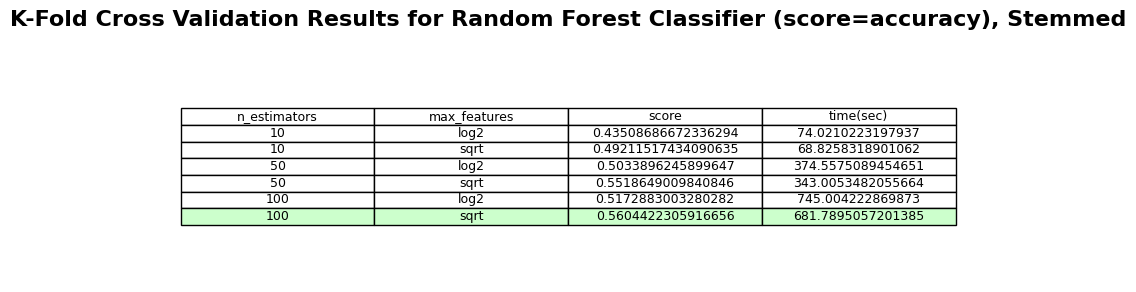

In [103]:
rf_best_params_stemmed_accuracy, rf_best_score_stemmed_accuracy = kfolds_CV(X_train_stemmed_tfidf, y_train, rf_params, "K-Fold Cross Validation Results for Random Forest Classifier (score=accuracy), Stemmed", accuracy_score, "RandomForestClassifier")

{'params': {'n_estimators': 10, 'max_features': 'log2'}, 'score': 0.4283332833540306, 'time(sec)': 72.49239492416382}
{'params': {'n_estimators': 10, 'max_features': 'sqrt'}, 'score': 0.49455185506154703, 'time(sec)': 68.88092875480652}
{'params': {'n_estimators': 50, 'max_features': 'log2'}, 'score': 0.4895919125695344, 'time(sec)': 366.53691720962524}
{'params': {'n_estimators': 50, 'max_features': 'sqrt'}, 'score': 0.5477696963385281, 'time(sec)': 336.0470070838928}
{'params': {'n_estimators': 100, 'max_features': 'log2'}, 'score': 0.5019812525062248, 'time(sec)': 729.9792051315308}
{'params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'score': 0.5509217882367817, 'time(sec)': 687.5040452480316}

Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best Score: 0.5509



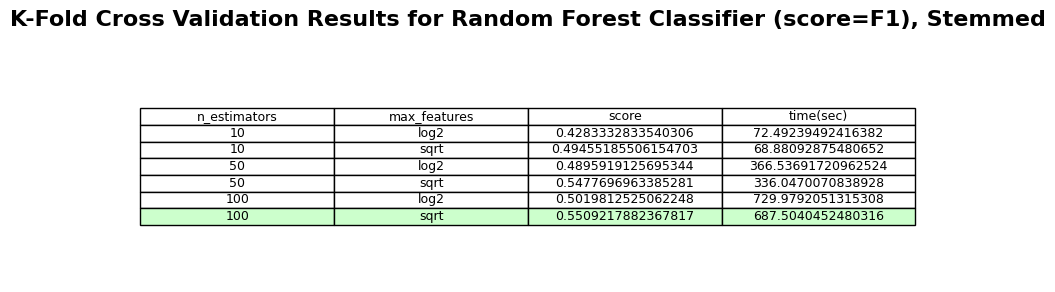

In [104]:
rf_best_params_stemmed_f1, rf_best_score_stemmed_f1 = kfolds_CV(X_train_stemmed_tfidf, y_train, rf_params, "K-Fold Cross Validation Results for Random Forest Classifier (score=F1), Stemmed", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "RandomForestClassifier")

In [105]:
# # params = {'n_estimators': [100, 200, 500],
# #           'max_depth': [None, 10, 20, 30],
# #           'min_samples_split': [2, 5, 10],
# #           'criterion': ['gini', 'entropy', 'log_loss']}

# rf_params = {'n_estimators': [10, 50, 100],
#              'max_features': [0.25, 0.5, "sqrt"]}

# rf_best_params = None
# rf_best_accuracy = 0
# rf_results = []

# for i, n_estimators in enumerate(rf_params['n_estimators']):
#   for j, max_features in enumerate(rf_params['max_features']):
#     model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
#     accuracies = []
    
#     start_time = time.time()

#     for train_folds, test_fold in get_kfolds(X_train_lemmatized_tfidf):
#       X_train_fold, y_train_fold = X_train_lemmatized_tfidf[train_folds], y_train[train_folds]
#       X_test_fold, y_test_fold = X_train_lemmatized_tfidf[test_fold], y_train[test_fold]

#       model.fit(X_train_fold, y_train_fold)

#       y_pred = model.predict(X_test_fold)
#       accuracy = accuracy_score(y_test_fold, y_pred)
#       accuracies.append(accuracy)
      
#     end_time = time.time()
    
#     run_time = end_time - start_time

#     avg_accuracy = np.mean(accuracies)
#     rf_results.append((n_estimators, max_features, avg_accuracy, run_time))

#     print(f"n_estimators={n_estimators}, max_features={max_features}, accuracy={avg_accuracy:.4f}, time={run_time:.3f}s")

#     if avg_accuracy > rf_best_accuracy:
#       rf_best_accuracy = avg_accuracy
#       rf_best_params = {"n_estimators": n_estimators, "max_features": max_features}

# print(f"Best Parameters: {rf_best_params}")
# print(f"Best Accuracy: {rf_best_accuracy:.4f}")

In [106]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.feature_extraction.text import TfidfVectorizer
# # from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report


# X = train_df["CleanedOriginalTweet"]
# y = train_df["Sentiment"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# print(len(X_train))

# tfidf = TfidfVectorizer()

# # # Initialize additional classifiers
# # svm_clf = SVC(kernel='linear', probability=True)  # Linear SVM
# logistic_regression = LogisticRegression()
# rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# # # Define pipelines for each classifier
# # svm = Pipeline([("tfidf", tfidf), ("svm", svm_clf)])
# lr = Pipeline([("tfidf", tfidf), ("logistic_regression", logistic_regression)])
# rf = Pipeline([("tfidf", tfidf), ("random_forest", rf_clf)])

# # # Fit the models
# # svm.fit(X_train, y_train)
# lr.fit(X_train, y_train)
# rf.fit(X_train, y_train)

# # # Make predictions
# # y_pred_svm = svm.predict(X_test)
# y_pred1 = lr.predict(X_test)
# y_pred_rf = rf.predict(X_test)

# # # Calculate accuracies
# # accuracy_svm = accuracy_score(y_test, y_pred_svm)
# accuracylr = accuracy_score(y_test, y_pred1)
# accuracy_rf = accuracy_score(y_test, y_pred_rf)

# # print("SVM Accuracy:", accuracy_svm)
# print("Logistic Regression Accuracy:", accuracylr)
# print("Random Forest Accuracy:", accuracy_rf)

# # Print additional evaluation metrics for Logistic Regression
# print("\nLogistic Regression:")
# print("Accuracy:", accuracy_score(y_test, y_pred1))
# print("Precision:", precision_score(y_test, y_pred1, average='weighted'))  # Adjusted for multiclass
# print("Recall:", recall_score(y_test, y_pred1, average='weighted'))
# print("F1 Score:", f1_score(y_test, y_pred1, average='weighted'))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))
# print("Classification Report:\n", classification_report(y_test, y_pred1))

# # Print additional evaluation metrics for Naive Bayes
# print("\nRandom Forest:")
# print("Accuracy:", accuracy_score(y_test, y_pred_rf))
# print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))  # Adjusted for multiclass
# print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
# print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
# print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Comparative Analysis of the Two Methods on the Dataset

This section covers a detailed comparison between the two machine learning models for the dataset across dimensions including computational complexity, performance, etc., as well as a final recommendation on the method that should go into production for this dataset.

In [107]:
pass

# Discussion on Ethical Issues for the Dataset/Task

This section provides a discussion on the ethical aspects of the machine learning task carried out on this dataset.

ETHICS!

# Bibliography

bib